# Simple classification problem

The following is an example notebook with classification problem. The data science problem here is kept intentionally small and trivial to understand. This is because I want to demonstrate about all kinds of ML Engineering challenges that might happen in production scenarios.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier


Read initial data

In [17]:
df = pd.read_csv(
    "data/historical_sensor_data.csv",
    sep=','
)
df.head()

,sensor_1,sensor_2,label
0,-0.940230,1.411390,0.0
1,0.266017,0.474068,0.0
2,1.912074,0.456729,1.0
3,0.414918,-0.504954,0.0
4,1.925371,0.129880,1.0


Data exploration

In [18]:
X = df[['sensor_1', 'sensor_2']].values
y = df[['label',]].values
print(X.shape)
print(y.shape)

(1500, 2)
(1500, 1)


Preprocess and obtain train and test data

In [19]:
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=99
)
h = 0.02 # meshgrid
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Plot the data

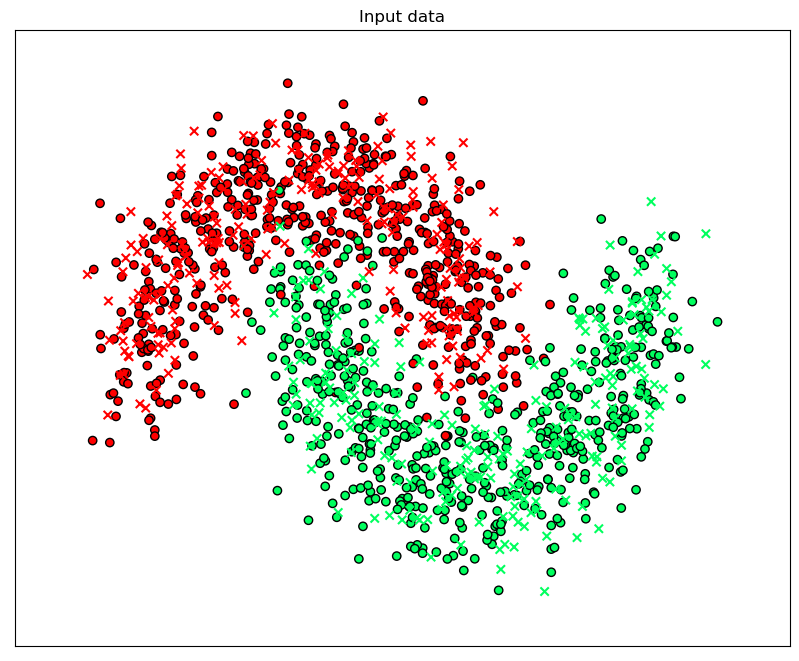

In [20]:
# just plot the dataset first
plt.figure(figsize=(10,8))
cm = plt.cm.PiYG
cm_bright = ListedColormap(["#FF0000", "#00ff5e"])
plt.title("Input data")
    
# Plot the training points
plt.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
)
# Plot the testing points
plt.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, marker='x',  cmap=cm_bright, alpha=1 
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()


Create and train model

In [21]:
clf = GaussianProcessClassifier(1.0 * RBF(1.0))
clf.fit(X_train, y_train.ravel())
score = clf.score(X_test, y_test)


Run Inference

In [22]:
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

Plot results of the inference

Text(2.4285906846024554, -2.5794945523084336, 'score = 0.98')

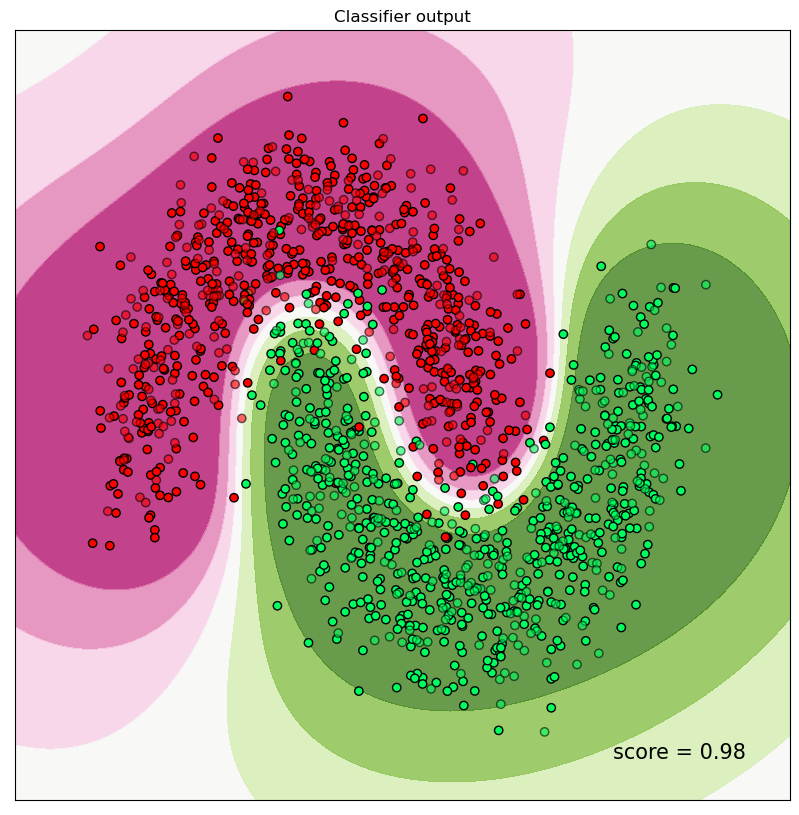

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

# Plot the training points
ax.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
)
# Plot the testing points
ax.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    cmap=cm_bright,
    edgecolors="k",
    alpha=0.6,
)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

ax.set_title("Classifier output")
ax.text(
    xx.max() - 0.3,
    yy.min() + 0.3,
    (f"score = {score:.2f}").lstrip("0"),
    size=15,
    horizontalalignment="right",
)

# Inference

Classification of the latest sensor data

## read the latest data

In [24]:

inference_df = pd.read_csv(
    "data/latest_sensor_data.csv",
    sep=','
)
X_inference = inference_df.values
inference_df.head()

,sensor_1,sensor_2
0,1.662361,0.465601
1,2.335964,0.670073
2,1.143369,0.732111
3,1.629260,1.322346
4,0.816851,1.795098


## predict labels

In [25]:
# predict labels
y_pred = clf.predict_proba(X_inference)[:, 1]
inference_df = inference_df.assign(y_pred = np.round(y_pred, 0))
inference_df.head()

,sensor_1,sensor_2,y_pred
0,1.662361,0.465601,1.0
1,2.335964,0.670073,1.0
2,1.143369,0.732111,1.0
3,1.629260,1.322346,1.0
4,0.816851,1.795098,0.0


# plot inference results

Text(0.5, 1.0, 'Classifier inference output')

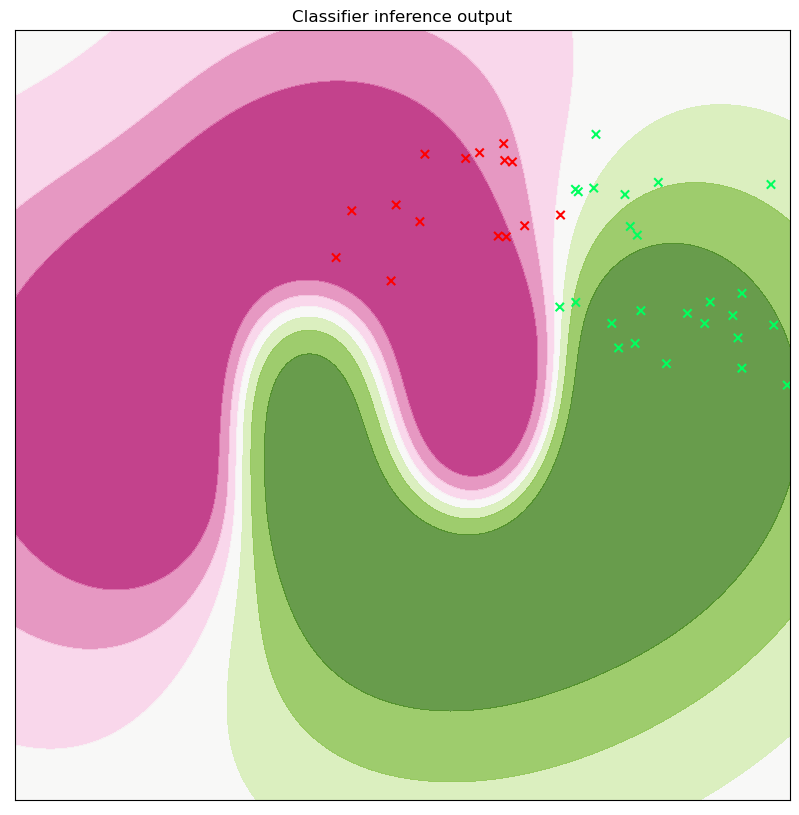

In [26]:
fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

# Plot the inference points
ax.scatter(
    X_inference[:, 0], X_inference[:, 1], marker="x", c=y_pred, cmap=cm_bright
)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

ax.set_title("Classifier inference output")


QUESTIONS:

a) How would you assess if a code is ready for production? What do you think about the given code
in model.ipynb?

The steps to acess if the given ML code is ready for production, we have to evaluate following:

1) Model Performance: The model should perform well on the inference part(unseen data) and outperform baseline performance metrics. The model evaluation strategy must be robust consisting of F1 score,accuracy, recall and precision. In this case, since we have equal distribution of classes in the training data, we can use accuracy, but I have used f1 score keeping in mind if we have to retrain model to maintain it for long time

2) Data quality : The model should be trained on high-quality, diverse, and representative data to prevent biases and ensure reliable performance.

3) Robustness: The code should be robust and handle errors, unexpected input

4) Documentation: The code should have documentation that covers all aspects of the project, including the problem statement, data sources, feature engineering, model selection, evaluation metrics, and deployment.

5) Model maintainance : Model should always give reliable results which can be assured by assessing its performance over time and tracking things like data drift, accuracy/f1 scoes over time, the code must be robust enough to handle it

6) Scalablity : The code should be scalable to handle large amounts of data along with easy integration with existing processes.

7) deployment: There should be a proper deployment plan

b. Would you change anything in the code? How and why? (Provide code examples)

c. How would you rearrange code for production system?

d. Would you add anything to the code? (Provide code examples)

Yes I would change following things in code(most of it is already implemented and availale in submitted code):
1) Moving away from jupyter notebooks: Jupyter notebooks are a really good and go to tool for a POC. But not recommended for production ready code due to their dynamic nature and lack of modularity. I would create a folder structure and an IDE based modular python code for a clean and clear execution.

2) Remove print statements: Generally I don't use print statements for a production code, I use logging to log this information since:
- logging is stored in a file or db
- it is easier to identify or isolate the issues
- Easy to parse because of structured logging
- flexibility compared to prints

3) Instead of printing, I would save the plots since they would be revisited/stored/accessed, used for nice display later

4) The inference data is not transformed(Note not "fit_transform" but using only "Tranform) in above code, which is inconsistent and results in poor performance. It is important to create a data pre processing pipeline although we have a clear training data, we can have possibe erros in in the inference data in future

5) It is assumed that a single gaussian process model which has high time and space complexity to be the ideal algorithm for the given case. There is no model selection implemented. There is no cross validation implemented to get more information and to avoid any kind of split bias.(All these changes are done in submitted code)

6) I would add things like model selection and cross validation. I have used various classification models of sklearn to evaluate the best one and the results can be seen in submitted code.

7) The code is also rearranged into an IDE based folder structure and since I did not know if I can submit the code in version control like GIT by giving access to my private repo, hence I have containarized it using docker.




e. Discuss training and inference data provided

Training data is used to fit the model to the underlying patterns and relationships in the data. Hence it's quality has significant importance on model performance. It should be representative of the target distribution(unknown function) and free from bias

In this case, we have data from two sensors which has been used to solve a business case as reresented in this notebook created by a data scientist. It is important to visualize this training data(which is already done in notebook) and see things like feature dependency, whether we have to use dimentionality reduction techniques like PCA,LDA etc, correlation among features, data distibution and patterns. For this reason in the pre processing step, I have introduced various plots like histogram, boxplot of features using matplotlib and pairplot,heatmap of features using seaborn. we can also do statistical feature dependecy test like pearson's correleation coefficient test(for linear relation) or non-parametric tests or visualizations. 

Also the pair plots indicates each feature is roughly normally distributed. But the feature 1 vs feature 2 pair plot is rougly rotated 90 degree in anti clockwise direction ompared to scatter plot of feature 2 vs feature 1, which indicated high negative correlation which indicates we can use something like feature selection, engineering or transformation depending on context. In this case I have used model selection and choose algorithm like SVM and random forest which can handle non linear relationship between features and negative correlation well


Inference data is used to make prediction utilizing the trained model. In this case we detect a covariate drift/ data drift in inference data compared to training data which might have been caused by bad split of training and test data(one of the reason)

f. How would you organize the codebase management. E.g. how do you deliver code to the production
environment? (make any assumption about code management system, that you like e.g.
GitHub, Bitbucket, GitLab, Azure Repos)

the approach to deliver code to production environment must be as follows:

- scalable and efficient code base

- using code management and version control system like git

- using clear branching like development branch or feature branch

- CI/CD

- code review - by one or more team members

- documentation - includes code documentation, architecture and dependencies

- release management
    
    

g. Would you consider any alternatives to the used algorithm and if so, why?

Yes gaussian process is a computation heavy algorithm and can be difficult to interpret. it can be used where probalistic predictions are important(like uncertainty estimation) and it often does good on small dataset.

The issue is that we shouldn't get fooled by accuracy values and often look at other metrics for choosing best algorithms like what is it's time and space complexity, how does it increase with data, ability to handle non linearity between features, negative correlations, requirement of the task(time complexity is huge risk as in safety critical sensors maintainance, for example)

Hence it is necessary to do a proper case study and results analysis of various algorithms before jumping on to the production.

h. Discuss pros and cons of your chosen algorithms as well as evaluation metrics.

The algorithm I have choosen(with limited knoledge about the problem in hand) is SVM(1st) Random forest(2nd) based on evaluation metric as mentioned above(which ever is possible in current set up). 
pros(RF): 
- ensemble based ML algorithm, easy to understand
- robust to outliers and noisy data(we dont seem to have much in training data, yet its a good practice)
- we can get a nice feature importance to understand contribution of each feature(although we might have guessed it intutively in the beginning with data visualization, we get a numerical proof of it now)
- it can handle negative correlation between features well( as we have in this case)

Cons(RF):
- Computationally expensive but less than gaussian process
- can overfit if not regularized well

SVM:
pros:
- Effective high dimensional spaces
- Robust to overfit
- versatile(thanks to kernels)
- multi class support
Cons:
- can be slow for large data sets
- difficult to interpret
- careful kernel choice and hyper parameter tuning


i. Discuss Big O notation of the algorithms, its algorithmic and memory complexity.

I have used random forest(best accuracy) and SVM(best overall) algorithm of scikit learn library. 

Algorithmic and memory complexity(RF) :

if m is number of trees and n in number of samples , its algo cmplexity is O(mn logm) and memory complexity is O(mn)

With respect to scalability to more/huge data, it has linear time and memory complexity

Algorithmic and memory complexity(SVM) :

Time complexity - O(n^3) -> n is number of training samples

memory complexity - O(n^2) -> n is number of training samples

j. List libraries in various programming languages that you know or have used that implement those
algorithms.

I have used the following:
- scikit learn
- tensorflow
- pytorch
- keras-rl, stable baselines, Rllib
- opencv

I am aware of many other like:
random forest of R
weka of Java 

k. Would your setup change if these were Databricks notebooks with Spark compute clusters behind
them, written in PySpark?

I am still trying to improve my knowledge in this area(especially in practice). based on my theorratical knowledge, I can say that it would change the set up for organizing code base and delivering code based on requirement of project. we should execute code in data bricks environment, run notebooks on spark clusters

*$PART 2: Cloud  Architecture$*

a. How would a cloud architecture look like and why?

One of the possible cloud architecture(says AWS) can look like :
1) store data on cloud service like amazon s3
2) load and preprocess dats using amazon EMR
3) train and deploy model using SageMaker
4) Monitor the deployed model using amazon CloudWatch
5) Anamolies, data drift etc can be detected and sent to clients via amazon SNS

Using services for the above operations reduces any overheads such that the time can be spent on develop/tune/improve models

b. What tools and implementation approach would you take?

1) Data storage
2) Pre processing
3) ML models

c. Which pipelines would you build there? How?

1) Data pre processing: s3 and EMR
2) ML pipeline: SageMaker
3) Deployment pipeline : SageMaker
4) Monitor Pipeline : Cloud Watch

d. Which assumptions have you made?

- assuming Zeiss is using cloud infrastructure like AWS(can be azure too, just an example)
- data is being collected and stored in secure location
- data is retreivable by data and ML pipeline
- data has already undergone certain requirement and ready to use(as required by data pipeline)

e. How can code management be done?

multiple ways:
1) Version control: git/SVN - for team collabaration and review
2) Code repository: to create issues, peer reviews
3) CI/CD - using AWS cloud pipeline

f. Discuss maintenance aspects (How to ensure the system will work for 1 year? 10 years?)

The following maintainance aspects thathas to be considered are:
1) Monitor the performance - to create an alert when there is a new trend/anamoly/data drift
2) cloud based data backup
3) performance optimization by tuning ML models, optimizing different infrastructures used for various steps like preprocessing, storage etc
4) security audits and update security patches
5) Constantly and safely updating the libraries used for ML models and infrastructure(very important since this ia fast growing field and hence there are frequent releases )

g. How would you integrate the near real time model updates (online training) with the once-a-day
slow full-update (batch training)?

- Online training is a scenario where we have a stream of data coming in and the model is continuously trained on the incoming data. While Batch training is once a day on a collected data on entire day. The integration of both types can be done by storing The real time model updates can be stored in a storage like s3, The full-update batch training process can retrieve the latest near real-time model updates and use them as the starting point for the training process. It can also be updated the real time model updates with batch training results

We should also make sure about the algorithms time complexity for inference(mainly) based on applications(for example your algorithm shouldn't detec an object in front the car after many seconds, it can be fatal). The inference pipeline must also consist of model maintainance to detect any data drift and outliers or analmolies. 

h. Discuss organisational aspects and challenges of a multi team setup.

IT should be similar to the ones in any project:
- Resource allocation 
- Decision making(set up process)
- Tasks assignment
- co-ordination - clear responsiblities
- having a broad idea of project that they are working towards common goal

i. How would your cloud architecture change if some data were external and collected outside the
ZEISS organisation?

- The data processing pipelines needs to be updated to accept the external data and to ensure that it is processed in a consistent manner by updating retreving data process(secure connection) and data storage processes
- implement security measures to keep the data safe
- access to such external data should be controlled since it can contain sensitive info.
- use data encryption
- use data transformation or dimentionality reduction methods if applicable